In [48]:
import json 
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
import pandas as pd
import numpy as np

In [49]:
comments_dir = "../data/filtered/comments"
posts_dir = "../data/filtered/posts"
google_data_files = ["../data/raw/google_trends_since_june_full_names.csv",
                      "../data/raw/google_trends_since_june_surnames.csv"]
polls_dir = "../data/raw/presidential_general_averages.csv"
output_dir = "../data/processed"

### Google trends

In [50]:
file_full_name = pd.read_csv(google_data_files[0], skiprows=1)
file_surname = pd.read_csv(google_data_files[1], skiprows=1)

# merge the two dataframes
google_df = pd.merge(file_full_name, file_surname, on="Día", how="inner")
print(google_df.columns)

# change column names

google_df.columns = ["date", "Kamala_Harris", "Joe_Biden", "Donald_Trump", "Harris", "Biden", "Trump"]

# replace "<1" with 0
google_df = google_df.replace("<1", 0)

# convert columns to numeric
google_df["Kamala_Harris"] = pd.to_numeric(google_df["Kamala_Harris"])
google_df["Joe_Biden"] = pd.to_numeric(google_df["Joe_Biden"])
google_df["Donald_Trump"] = pd.to_numeric(google_df["Donald_Trump"])
google_df["Harris"] = pd.to_numeric(google_df["Harris"])
google_df["Biden"] = pd.to_numeric(google_df["Biden"])
google_df["Trump"] = pd.to_numeric(google_df["Trump"])

google_df['all_Kamala_Harris'] = (google_df['Kamala_Harris'] + google_df['Harris']) / 2
google_df['all_Joe_Biden'] = (google_df['Joe_Biden'] + google_df['Biden']) / 2
google_df['all_Donald_Trump'] = (google_df['Donald_Trump'] + google_df['Trump']) / 2

google_df

Index(['Día', 'Kamala Harris: (Estados Unidos)', 'Joe Biden: (Estados Unidos)',
       'Donald Trump: (Estados Unidos)', 'Harris: (Estados Unidos)',
       'Biden: (Estados Unidos)', 'Trump: (Estados Unidos)'],
      dtype='object')


,date,Kamala_Harris,Joe_Biden,Donald_Trump,Harris,Biden,Trump,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0,1,6,1,1,6,0.5,1.0,6.0
1,2024-06-02,0,1,5,1,1,5,0.5,1.0,5.0
2,2024-06-03,0,1,3,1,1,4,0.5,1.0,3.5
3,2024-06-04,0,1,3,1,2,3,0.5,1.5,3.0
4,2024-06-05,0,1,2,1,2,3,0.5,1.5,2.5
...,...,...,...,...,...,...,...,...,...,...
114,2024-09-23,2,0,3,3,0,4,2.5,0.0,3.5
115,2024-09-24,2,0,4,2,0,4,2.0,0.0,4.0
116,2024-09-25,2,0,3,3,0,4,2.5,0.0,3.5
117,2024-09-26,2,0,3,3,0,4,2.5,0.0,3.5


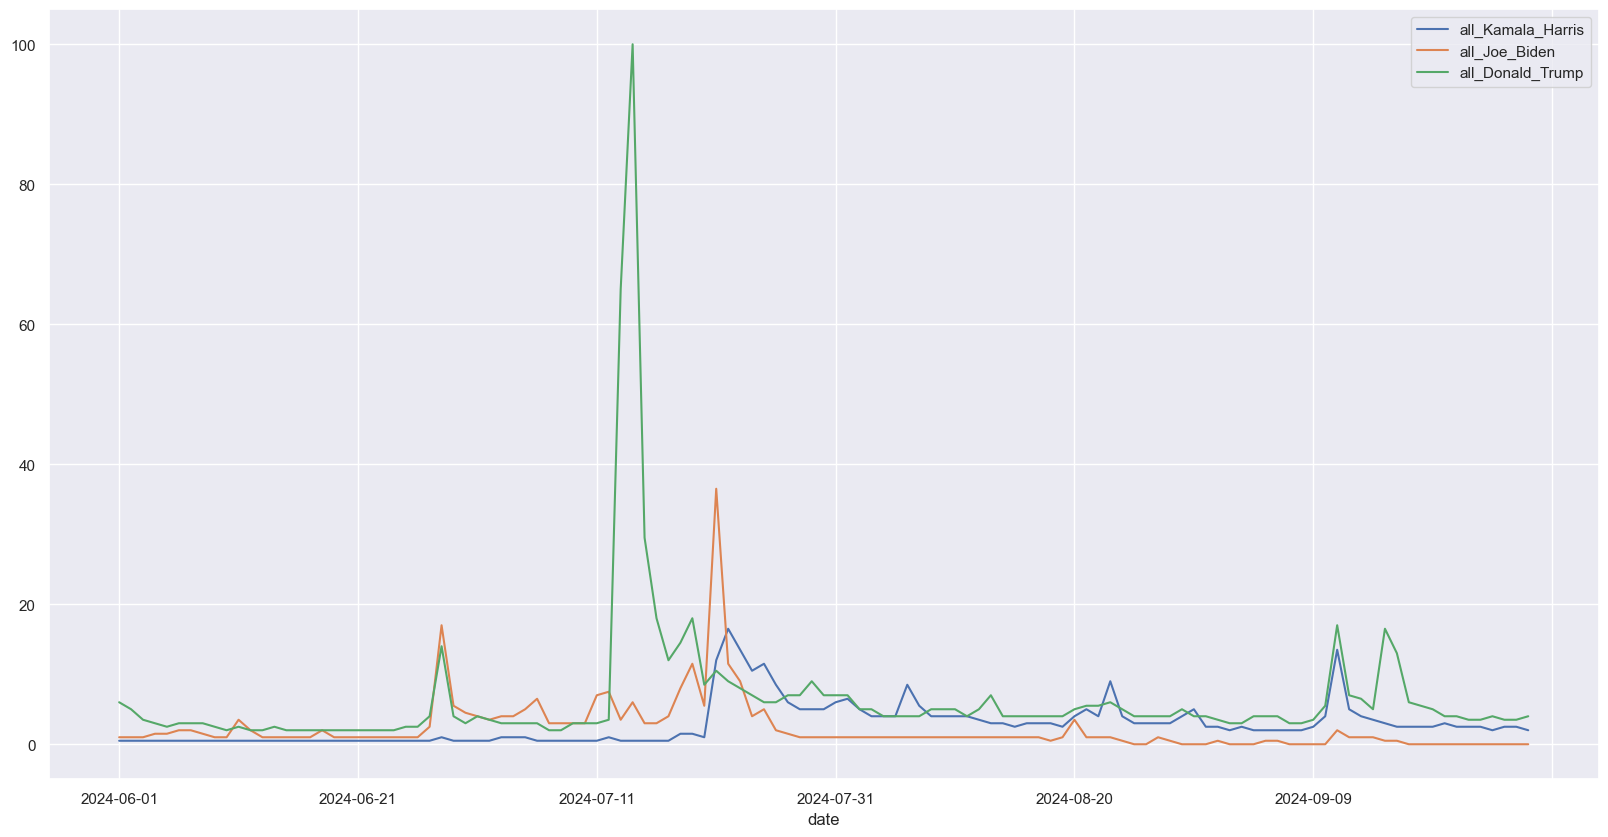

In [51]:
# plot all kamala, all biden, all trump
google_df.plot(x='date', y=['all_Kamala_Harris', 'all_Joe_Biden', 'all_Donald_Trump'], figsize=(20, 10))
plt.show()

In [52]:
google_df.to_csv(os.path.join(output_dir, "google_trends.csv"), columns=["date", "all_Kamala_Harris", "all_Joe_Biden", "all_Donald_Trump"], index=False)

### Presidential polls

In [53]:
# read polls data
polls_df = pd.read_csv(polls_dir)

# get data from 2024-06-01 to 2024-09-27
polls_df = polls_df[polls_df["date"] >= "2024-06-01"]
polls_df = polls_df[polls_df["date"] <= "2024-09-27"]

polls_df.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
21354,Trump,2024-09-27,NaN,Arizona,2024,REP,48.03695,49.472240,46.647695
21355,Harris,2024-09-27,NaN,Arizona,2024,DEM,46.76445,48.279405,45.246513
21356,Trump,2024-09-26,NaN,Arizona,2024,REP,47.89430,49.230528,46.461395
21357,Harris,2024-09-26,NaN,Arizona,2024,DEM,47.07260,48.606225,45.628150
21358,Trump,2024-09-25,NaN,Arizona,2024,REP,47.91320,49.456457,46.390183


In [54]:
polls_df.isna().sum()

candidate                0
date                     0
pct_trend_adjusted    3312
state                    0
cycle                    0
party                    0
pct_estimate             0
hi                       0
lo                       0
dtype: int64

In [55]:
polls_df.drop(columns=["pct_trend_adjusted"], inplace=True)

In [56]:
polls_df.sort_values(by="date", inplace=True)

In [57]:
# create a new df with date, candidate and mean of pct_estimate

polls_df_2 = polls_df.groupby(["date", "candidate"]).agg({"pct_estimate": "mean"}).reset_index()
polls_df_2

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Kennedy,9.181320
2,2024-06-01,Trump,42.883383
3,2024-06-02,Biden,38.705211
4,2024-06-02,Kennedy,9.238094
...,...,...,...
311,2024-09-25,Trump,46.302787
312,2024-09-26,Harris,48.572300
313,2024-09-26,Trump,46.183492
314,2024-09-27,Harris,48.466126


In [12]:
# drop where candidate is Kennedy
polls_df_2 = polls_df_2[polls_df_2["candidate"] != "Kennedy"]

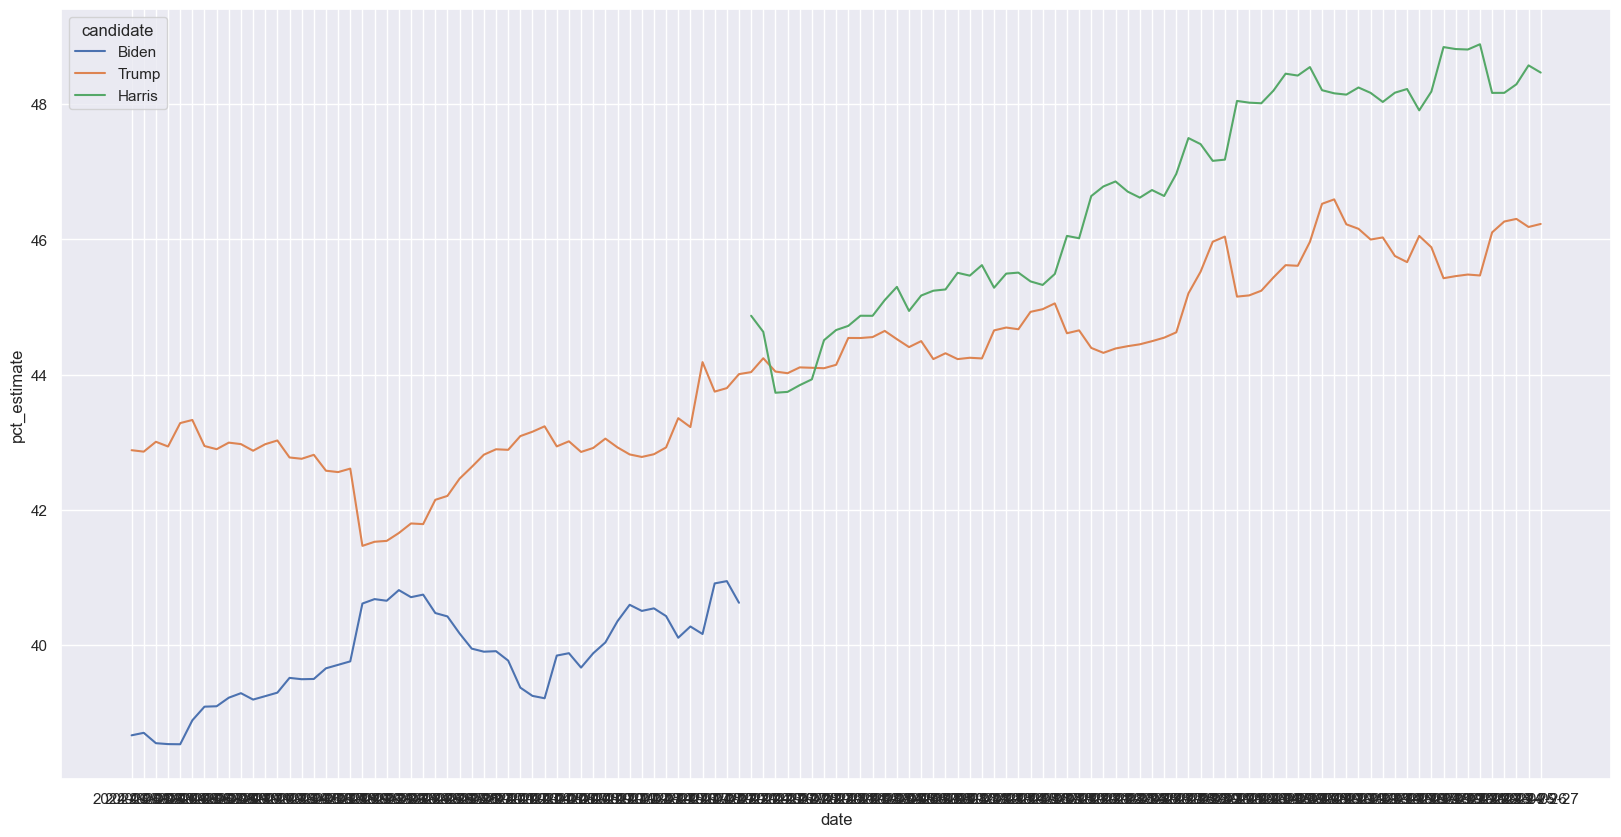

In [15]:
# plot by candidate over time
sns.set(rc={'figure.figsize':(20,10)})

sns.lineplot(data=polls_df_2, x="date", y="pct_estimate", hue="candidate")
plt.show()

In [16]:
polls_df_2.to_csv(os.path.join(output_dir, "polls.csv"), index=False)

### Comments

In [17]:
def is_valid_comment(comment):
    body = comment["body"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body):
        return True
    return False

In [18]:
final_df = pd.DataFrame()


for file in os.listdir(comments_dir):
    # read json file
    df = pd.read_json(os.path.join(comments_dir, file), lines=True) 

    # filter by valid comments
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]

    # remove columns
    df.drop(columns=["is_valid", "created", "author"], inplace=True)

    # convert to date
    df['date_day'] = df['datetime'].dt.date

    # remove links from body
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    final_df = pd.concat([final_df, df])

    
final_df.head()

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
1,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
6,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
14,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
15,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
19,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01


In [19]:
final_df.to_csv(os.path.join(output_dir, "comments.csv"), index=False)

### Posts

In [21]:
def is_valid_post(post):
    body = post["body"].lower()
    title = post["title"].lower()
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    if re.search(regex, body) or re.search(regex, title):
        return True
    return False

In [22]:
final_df = pd.DataFrame()

for file in os.listdir(posts_dir):
    if file.endswith(".txt"):
        continue

    # read json file
    df = pd.read_json(os.path.join(posts_dir, file), lines=True) 

    # filter by valid comments
    bodies = df["body"].tolist()
    df['is_valid'] = df.apply(is_valid_comment, axis=1)
    df = df[df["is_valid"]]

    # remove columns
    df.drop(columns=["is_valid", "created", "author", "id", "subreddit_id", "url"], inplace=True)

    # convert to date
    df['date_day'] = df['datetime'].dt.date

    # remove links from body
    df['body'] = df['body'].apply(lambda x: re.sub(r"http\S+", "", x))
    
    final_df = pd.concat([final_df, df])

final_df.head()

,subreddit,name,datetime,score,ratio,title,body,date_day
1,Conservative,t3_1d5b2pn,2024-06-01 02:57:34,0,0.14,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01
2,Conservative,t3_1d5b496,2024-06-01 03:00:01,0,0.36,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01
5,Conservative,t3_1d5cxhf,2024-06-01 04:39:48,0,0.48,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01
7,Conservative,t3_1d5fbhl,2024-06-01 06:58:11,0,0.50,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01
11,Conservative,t3_1d5ti3t,2024-06-01 20:31:24,95,0.65,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01


In [23]:
final_df.to_csv(os.path.join(output_dir, "posts.csv"), index=False)

### All data joined together

In [58]:
posts = pd.read_csv(os.path.join(output_dir, "posts.csv"))
comments = pd.read_csv(os.path.join(output_dir, "comments.csv"))
polls = pd.read_csv(os.path.join(output_dir, "polls.csv"))
google = pd.read_csv(os.path.join(output_dir, "google_trends.csv"))

In [59]:
polls.head()

,date,candidate,pct_estimate
0,2024-06-01,Biden,38.668283
1,2024-06-01,Trump,42.883383
2,2024-06-02,Biden,38.705211
3,2024-06-02,Trump,42.862000
4,2024-06-03,Biden,38.551967


In [60]:
google.head()

,date,all_Kamala_Harris,all_Joe_Biden,all_Donald_Trump
0,2024-06-01,0.5,1.0,6.0
1,2024-06-02,0.5,1.0,5.0
2,2024-06-03,0.5,1.0,3.5
3,2024-06-04,0.5,1.5,3.0
4,2024-06-05,0.5,1.5,2.5


In [61]:
# create a json with posts and add a field "type" with value "post", do the same with comments
posts["type"] = "post"
comments["type"] = "comment"

json_posts = posts.to_dict(orient="records")
json_comments = comments.to_dict(orient="records")

# join the two lists

json_data = json_posts + json_comments

polls_candidate_names = polls["candidate"].unique()

google_columns_candidate_names = list(google.columns[1:4])

for doc in json_data:
    # get the date
    date = doc["date_day"]
    for candidate in polls_candidate_names:

        # get the value of the candidate in the polls on said date
        polls_value = polls[(polls["date"] == date) & (polls["candidate"] == candidate)]["pct_estimate"].values
        if len(polls_value) > 0:
            doc[f'polls_{candidate}'] = polls_value[0]
        else:
            doc[f'polls_{candidate}'] = None

    for candidate in google_columns_candidate_names:
        # get the value of the candidate in the google trends on said date
        google_value = google[google["date"] == date][candidate].values
        if len(google_value) > 0:
            doc[f"google_{candidate.split('_')[-1]}"] = google_value[0]
        else:
            doc[f"google_{candidate.split('_')[-1]}"] = None

json_data[0]

    


{'subreddit': 'Conservative',
 'name': 't3_1d5b2pn',
 'datetime': '2024-06-01 02:57:34',
 'score': 0,
 'ratio': 0.140000000596046,
 'title': 'Where can I get a T-shirt?',
 'body': 'I’m looking for\n\n\nYELLIN FOR THE FELLON\n               VOTE\n      TRUMP 2024',
 'date_day': '2024-06-01',
 'type': 'post',
 'polls_Biden': 38.668283333333335,
 'polls_Trump': 42.883383333333335,
 'polls_Harris': None,
 'google_Harris': 0.5,
 'google_Biden': 1.0,
 'google_Trump': 6.0}

In [63]:
# create a dataframe from the json
df = pd.DataFrame(json_data)

# drop columns name, datetime, post_id, id, parent, ratio, upvotes, type and score from the dataframe
df.drop(columns=["name", "datetime", "post_id", "id", "parent", "ratio", "upvotes", "type", "score", "subreddit"], inplace=True)

# filter by date_day being <= 2024-09-27
df = df[df["date_day"] <= "2024-09-27"]

# apply .fillna(0) to 'polls_Biden' and 'polls_Harris' columns
df.loc[:, ['polls_Biden', 'polls_Harris']] = df.loc[:, ['polls_Biden', 'polls_Harris']].fillna(0)

# apply .fillna(' ') to 'title' column
df['title'] = df['title'].fillna(' ')

df

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump
0,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
1,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
2,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
3,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
4,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0
...,...,...,...,...,...,...,...,...,...
141162,,You misspelled Donald Trump and JD Vance.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141163,,Trump doesn't want Ukraine to surrender.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141164,,I have yet to see any sort of evidence that th...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0
141165,,If you live in North Carolina or Georgia pleas...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0


In [64]:
df.to_csv(os.path.join(output_dir, "final_dataset.csv"), index=False)

In [66]:
# join the sentiment analysis data to the df on index
sentiment = pd.read_csv("../data/processed/love_hate.csv")

df = df.join(sentiment)
df

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
0,Where can I get a T-shirt?,I’m looking for\n\n\nYELLIN FOR THE FELLON\n ...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,great summary on the commie dirtbag nonsense,[\n\nCNN Senior Legal Analyst Describes How Th...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0,0.000000,0.000000,0.575917,0.424083,0.000000,0.000000
2,Will local Texas DAs start grand jury investig...,Since 2021 millions of migrants have been allo...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0,0.543043,0.456957,0.000000,0.000000,0.000000,0.000000
3,Good news about Trump's verdict,MAGA Senators are making a stand. Within 48 h...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0,0.000000,0.000000,0.565068,0.434932,0.000000,0.000000
4,Minority voters respond to the Trump verdict.,[\n\n[\n\n[\n\n[\n\n[\n\n[\n\n[\n\nTL;DR: Min...,2024-06-01,38.668283,42.883383,0.000000,0.5,1.0,6.0,0.485946,0.514054,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141162,,You misspelled Donald Trump and JD Vance.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0,0.000000,0.000000,0.000000,0.000000,0.414675,0.585325
141163,,Trump doesn't want Ukraine to surrender.,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0,0.195985,0.804015,0.000000,0.000000,0.000000,0.000000
141164,,I have yet to see any sort of evidence that th...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0,0.332384,0.667616,0.000000,0.000000,0.000000,0.000000
141165,,If you live in North Carolina or Georgia pleas...,2024-09-27,0.000000,46.227953,48.466126,2.0,0.0,4.0,0.333486,0.666514,0.000000,0.000000,0.000000,0.000000


In [69]:
df[df["body"].isna()]

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
93,Supreme Court rules in favor of presidential i...,NaN,2024-07-01,39.911904,42.896904,0.000000,0.5,4.0,4.0,0.291432,0.708568,0.417393,0.582607,0.000000,0.000000
121,Democrats are setting up Trump for an economic...,NaN,2024-07-08,39.669587,42.857650,0.000000,0.5,3.0,2.0,0.325803,0.674197,0.288529,0.711471,0.000000,0.000000
221,Hillary is running again?,NaN,2024-07-21,40.627858,44.008192,0.000000,12.0,36.5,10.5,0.000000,0.000000,0.368879,0.631121,0.000000,0.000000
275,Kamala Harris won't preside over Netanyahu's s...,NaN,2024-07-23,0.000000,NaN,0.000000,13.5,9.0,8.0,0.000000,0.000000,0.591883,0.408117,0.000000,0.000000
312,Trump says he will be returning for another ra...,NaN,2024-07-26,0.000000,44.045975,43.732825,8.5,2.0,6.0,0.317731,0.682269,0.306586,0.693414,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138744,,NaN,2024-09-11,0.000000,46.222683,48.140017,13.5,2.0,17.0,0.314849,0.685151,0.000000,0.000000,0.000000,0.000000
138810,,NaN,2024-09-11,0.000000,46.222683,48.140017,13.5,2.0,17.0,0.000000,0.000000,0.000000,0.000000,0.840875,0.159125
138872,,NaN,2024-09-11,0.000000,46.222683,48.140017,13.5,2.0,17.0,0.334159,0.665841,0.000000,0.000000,0.000000,0.000000
138877,,NaN,2024-09-11,0.000000,46.222683,48.140017,13.5,2.0,17.0,0.322181,0.677819,0.000000,0.000000,0.271823,0.728177


In [68]:
# show the rows where polls_Trump in nan

df[df["polls_Trump"].isna()]

,title,body,date_day,polls_Biden,polls_Trump,polls_Harris,google_Harris,google_Biden,google_Trump,donald_trump_love,donald_trump_hate,joe_biden_love,joe_biden_hate,kamala_harris_love,kamala_harris_hate
231,It's a sad day for democracy,"Clooney, Obama, Pelosi, and numerous other pow...",2024-07-22,0.0,NaN,0.0,16.5,11.5,9.0,0.093650,0.906350,0.041855,0.958145,0.000000,0.000000
232,"Dad, Please Sign My Pardon Before You.....",Biden said he would not pardon Hunter. \nBide...,2024-07-22,0.0,NaN,0.0,16.5,11.5,9.0,0.000000,0.000000,0.324819,0.675181,0.000000,0.000000
233,Joe Manchin may enter the race.,This could get very interesting. Would throw a...,2024-07-22,0.0,NaN,0.0,16.5,11.5,9.0,0.405793,0.594207,0.442446,0.557554,0.000000,0.000000
234,Richard Iritano.\n\nFrom pee pads—to knee pads...,"\n\nstay frosty, folks... lots of folks like t...",2024-07-22,0.0,NaN,0.0,16.5,11.5,9.0,0.254313,0.745687,0.000000,0.000000,0.000000,0.000000
235,The Bernie Gang Is Starting To Pop Up At the News,I’m starting to see “Bernie Sanders 2024!!” Po...,2024-07-22,0.0,NaN,0.0,16.5,11.5,9.0,0.113589,0.886411,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86397,,"I noticed that after I linked it, I was in the...",2024-07-23,0.0,NaN,0.0,13.5,9.0,8.0,0.000000,0.000000,0.272207,0.727793,0.000000,0.000000
86398,,Update! You're half right! There WERE office...,2024-07-23,0.0,NaN,0.0,13.5,9.0,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86399,,UPDATE! There WERE officers assigned to watch...,2024-07-23,0.0,NaN,0.0,13.5,9.0,8.0,0.000000,0.000000,0.000000,0.000000,0.231802,0.768198
86400,,She would represent a material threat to Trump...,2024-07-23,0.0,NaN,0.0,13.5,9.0,8.0,0.086217,0.913783,0.000000,0.000000,0.258460,0.741540


In [67]:
# count nan values in the dataframe
df.isna().sum()

title                    0
body                   299
date_day                 0
polls_Biden              0
polls_Trump           4547
polls_Harris             0
google_Harris            0
google_Biden             0
google_Trump             0
donald_trump_love        1
donald_trump_hate        1
joe_biden_love           1
joe_biden_hate           1
kamala_harris_love       1
kamala_harris_hate       1
dtype: int64

### Sentiment

In [2]:
from transformers import pipeline
pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device='cuda')

In [4]:
# Function to find entities in a text
def find_entities(text):
    entities = []
    regex = r"(biden|trump|harris|donald|joe|kamala)"
    for match in re.finditer(regex, text.lower()):
        entities.append(match.group())
    return entities


def get_sentiment_labels_entity(entity):
    return [f'{entity}_positive', f'{entity}_negative']

def get_sentiment_towards_entity(text, entity):
    labels = get_sentiment_labels_entity(entity)
    sentiment_entry = pipe(text, labels)
    custom_order = [f'{entity}_positive', f'{entity}_negative']
    label_score_map = dict(zip(sentiment_entry['labels'], sentiment_entry['scores']))
    sorted_labels = sorted(sentiment_entry['labels'], key=lambda x: custom_order.index(x))
    sorted_scores = [label_score_map[label] for label in sorted_labels]
    return {"labels": sorted_labels, "scores": sorted_scores}

text = "No one outside of over online political junkies and insiders care about that. Harris is not electable in the general. If the DNC was smart they\u2019d listen to the data instead of their internal party structures that have left us with a possible trump second term and a fascist Supreme Court."




def process_sentiment(text):
    entities = find_entities(text)
    result = {}

    new_entities = ['donald_trump', 'joe_biden', 'kamala_harris']

    for mixed_entity in new_entities:
        roots = mixed_entity.split("_")
        final_sum = np.zeros(2)
        is_in_text = 0
        for r in roots:
            if r in entities:
                is_in_text += 1
                sentiment = get_sentiment_towards_entity(text, r)
                final_sum += np.array(sentiment["scores"])

        if is_in_text > 0:
            final_sum = final_sum / is_in_text
            result[mixed_entity] = {"labels": ["positive", "negative"], "scores": final_sum.tolist()}
        else:
            result[mixed_entity] = {"labels": ["positive", "negative"], "scores": [0, 0]}




    return result

process_sentiment(text)


{'donald_trump': {'labels': ['positive', 'negative'],
  'scores': [0.36486729979515076, 0.6351327300071716]},
 'joe_biden': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'kamala_harris': {'labels': ['positive', 'negative'],
  'scores': [0.19313164055347443, 0.8068683743476868]}}

In [7]:
df = pd.read_csv(os.path.join(output_dir, "final_dataset.csv"))

In [20]:
text = df.iloc[141162]["body"]
print(text)

process_sentiment(text)

Do not be deceived Tim Walz and Kamala Harris are secretly collaborating as part of a broader agenda to seize control of the U.S. government by exploiting crises like the COVID-19 pandemic, encouraging social unrest, and manipulating elections. Their ultimate goal is to establish a socialist regime that undermines the Constitution, centralizes power, and dismantles law enforcement, using their influence to pave the way for a radical transformation of the country


{'donald_trump': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'joe_biden': {'labels': ['positive', 'negative'], 'scores': [0, 0]},
 'kamala_harris': {'labels': ['positive', 'negative'],
  'scores': [0.33642561733722687, 0.6635743975639343]}}

In [11]:
import tqdm
columns = ['donald_trump_positive', 'donald_trump_negative', 'joe_biden_positive', 'joe_biden_negative', 'kamala_harris_positive', 'kamala_harris_negative']
candidates = ['donald_trump', 'joe_biden', 'kamala_harris']
sentiment_df = pd.DataFrame(columns=columns)
for index, row in tqdm.tqdm(df.iterrows()):
    text = row['title'] + " " + row['body']
    sentiment = process_sentiment(text)
    row_values = []
    for candidate in candidates:
        row_values += sentiment[candidate]["scores"]
    sentiment_df.loc[index] = row_values

sentiment_df.head()
        



141167it [2:03:13, 19.09it/s]


,donald_trump_positive,donald_trump_negative,joe_biden_positive,joe_biden_negative,kamala_harris_positive,kamala_harris_negative
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.663439,0.336561,0.0,0.0
2,0.528612,0.471388,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.568892,0.431108,0.0,0.0
4,0.627601,0.372399,0.000000,0.000000,0.0,0.0


In [19]:
sentiment_df.iloc[141162]

donald_trump_positive     0.000000
donald_trump_negative     0.000000
joe_biden_positive        0.000000
joe_biden_negative        0.000000
kamala_harris_positive    0.330522
kamala_harris_negative    0.669478
Name: 141162, dtype: float64

In [12]:
sentiment_df.to_csv(os.path.join(output_dir, "sentiment.csv"), index=False)